# Gaussian Distribution tests

This notebook looks at the time it takes to create kernal density estimations with KDEpy, sklearn, and statsmodels.

In [1]:
import KDEpy
import sklearn.neighbors
import statsmodels.nonparametric.kernel_density as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import resource
#resource.setrlimit(resource.RLIMIT_AS, (2048, 2048))

In [2]:
def gaussian_kdes(sample_sizes, dims, buckets, N=5, kernal="gaussian"):
    testing = pd.DataFrame(columns=["method", "sample_size", "dim","bucket",
                                    "time", "sd_time", "success"])
    methods = ["kdepy", "sklearn", "statsmodels"]
    
    for sample_size in sample_sizes:
        for dim in dims:
            for bucket in buckets:
                for method in methods:
                    data = np.random.randn(sample_size, dim)
                    total_time = []
                    for n in range(N):
                        start = time.time()
                        if method == "kdepy":
                            try:
                                kde = KDEpy.FFTKDE(kernel=kernal, norm=2)
                                grid, points = kde.fit(data).evaluate(bucket)
                                success = 1                    
                            except MemoryError:
                                success = 0
                        elif method == "sklearn":
                            try:
                                kde = sklearn.neighbors.KernelDensity(kernel=kernal,
                                                                      bandwidth = 1/bucket)
                                kde.fit(data)
                                success = 1                    
                            except MemoryError:
                                success = 0
                        elif method == "statsmodels":
                            try:
                                kde = sm.KDEMultivariate(data,
                                                         var_type="c"*dim,
                                                         bw=1/bucket)
                                succuss = 1
                            except MemoryError:
                                success = 0
                        end = time.time()
                        total_time.append(end - start)
                    testing = testing.append(
                        pd.DataFrame({"method": method,
                                      "sample_size" : int(sample_size),
                                      "dim" : int(dim),
                                      "bucket" : int(bucket),
                                      "time": np.mean(end - start),
                                      "sd_time": np.std(total_time),
                                      "success": success}, index=[0]), ignore_index=True)
    testing["p_sd_time"] = testing.time + testing.sd_time
    testing["n_sd_time"] = testing.time - testing.sd_time                         
    return testing, kde

In [3]:
sample_sizes = [10**i for i in range(2, 7)]
dims = list(range(2,9))
buckets = [10*i for i in range(1, 3)]

testing, kde = gaussian_kdes(sample_sizes, dims, buckets, N=1)
testing

,method,sample_size,dim,bucket,time,sd_time,success,p_sd_time,n_sd_time
0,kdepy,100,2,10,0.004801,0.0,1,0.004801,0.004801
1,sklearn,100,2,10,0.000490,0.0,1,0.000490,0.000490
2,statsmodels,100,2,10,0.000060,0.0,1,0.000060,0.000060
3,kdepy,100,2,20,0.003331,0.0,1,0.003331,0.003331
4,sklearn,100,2,20,0.000183,0.0,1,0.000183,0.000183
5,statsmodels,100,2,20,0.000036,0.0,1,0.000036,0.000036
6,kdepy,100,3,10,0.002688,0.0,1,0.002688,0.002688
7,sklearn,100,3,10,0.000164,0.0,1,0.000164,0.000164
8,statsmodels,100,3,10,0.000030,0.0,1,0.000030,0.000030
9,kdepy,100,3,20,0.005874,0.0,1,0.005874,0.005874


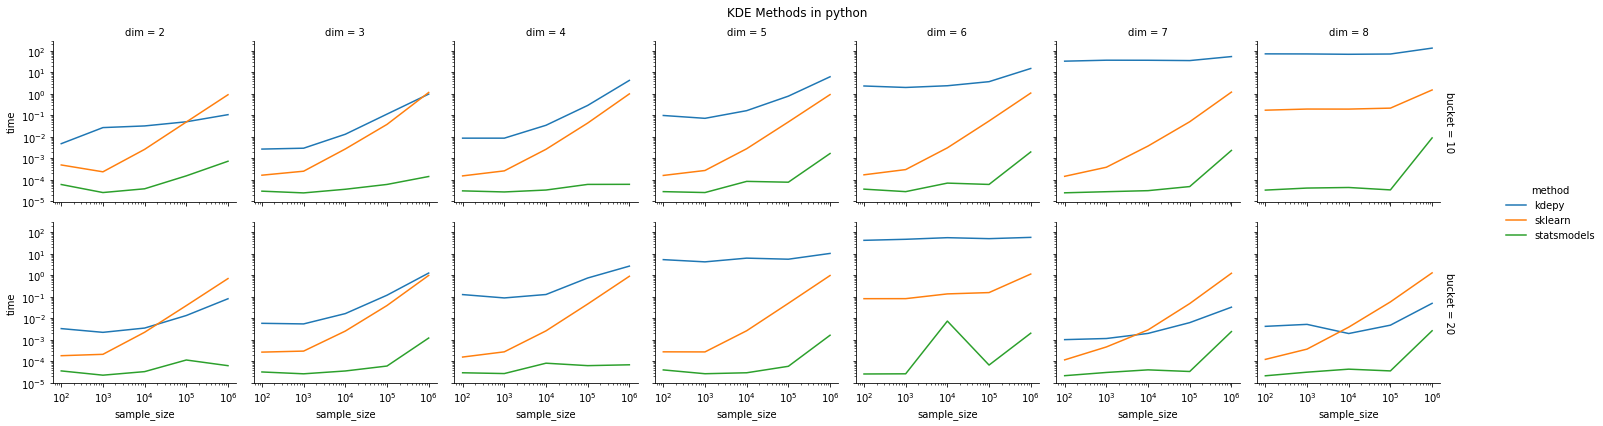

In [4]:
# TODO confidence intervals
g = sns.FacetGrid(testing, hue="method", row="bucket", col="dim", margin_titles=True);
g.map(plt.loglog, "sample_size", "time");
g.add_legend();
plt.subplots_adjust(top=0.9);
g.fig.suptitle('KDE Methods in python');
